## sprint23 　　　seq2seq

## 【問題1】機械翻訳の実行とコードリーディング

In [ ]:
###★入力データの整理　###
###★モデルの定義。エンコーダ側のLSTMとデコーダ側のLSTM。###
### keras functionalでの記述。２つの入力（encoder_input_dataとdecoder_input_data）から1つの出力（decoder_target_data）
###★ 推論用の関数decode_sequenceの定義。###
###★ 学習後の推論処理。翻訳元の英語をインプットし翻訳結果の仏語をアウトプットする。range(文章の数)###

In [1]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np


###★入力データの整理　###
batch_size = 64  # Batch size for training.
epochs = 3  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)



Using TensorFlow backend.


Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [2]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.


In [7]:
###★モデルの定義。エンコーダ側のLSTMとデコーダ側のLSTM★###
### keras functionalでの記述。２つの入力（encoder_input_dataとdecoder_input_data）から1つの出力（decoder_target_data）
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

# 推論用の関数decode_sequenceの定義。
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

Train on 8000 samples, validate on 2000 samples
Epoch 1/3
8000/8000 [==============================] - 49s 6ms/step - loss: 1.1654 - accuracy: 0.7258 - val_loss: 1.0359 - val_accuracy: 0.7085
Epoch 2/3
8000/8000 [==============================] - 45s 6ms/step - loss: 0.8396 - accuracy: 0.7730 - val_loss: 0.8399 - val_accuracy: 0.7659
Epoch 3/3
8000/8000 [==============================] - 62s 8ms/step - loss: 0.6671 - accuracy: 0.8112 - val_loss: 0.6960 - val_accuracy: 0.7993


In [5]:
### 学習後の推論処理。翻訳元の英語をインプットし翻訳結果の仏語をアウトプットする。range(文章の数)
for seq_index in range(30):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Ateste de le te !

-
Input sentence: Hi.
Decoded sentence: C'est ent pait.

-
Input sentence: Hi.
Decoded sentence: C'est ent pait.

-
Input sentence: Run!
Decoded sentence: Arente de le !

-
Input sentence: Run!
Decoded sentence: Arente de le !

-
Input sentence: Who?
Decoded sentence: Ateste de le te !

-
Input sentence: Wow!
Decoded sentence: Arente de le !

-
Input sentence: Fire!
Decoded sentence: Arente de le !

-
Input sentence: Help!
Decoded sentence: Atestez le le te !

-
Input sentence: Jump.
Decoded sentence: Arente de !

-
Input sentence: Stop!
Decoded sentence: Arente de le !

-
Input sentence: Stop!
Decoded sentence: Arente de le !

-
Input sentence: Stop!
Decoded sentence: Arente de le !

-
Input sentence: Wait!
Decoded sentence: Arente de !

-
Input sentence: Wait!
Decoded sentence: Arente de !

-
Input sentence: Go on.
Decoded sentence: Arente de !

-
Input sentence: Go on.
Decoded sentence: Arente de !

-
Input sentence: Go on.


In [ ]:
＜メモ＞
温度ｔを調節するなど。
学習回数によって、高頻度に寄ってくるのでエポック数が高くなりすぎるのも問題であると思われる。
１回間違えたら、間違えっぱなし？（教師強制ではないため？）

## 【問題2】イメージキャプショニングの学習済みモデルの実行
　グーグルコラボによる実行。
 
 https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning/README.md
 

下記を順番に実行する。  
git clone https://github.com/pdollar/coco.git  
cd coco/PythonAPI/  
make  
python setup.py build  
python setup.py install  
cd ../../  
git clone https://github.com/yunjey/pytorch-tutorial.git  
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/  
　  
mkdir data  
mkdir models  
　  
これらのディレクトリに、「pretrained model」からダウンロードされた「pretrained model」と「the vocabulary file」をアップロードし、sample.pyを実行する。    
　  
!python sample.py --image='png/sunflower.jpg'  

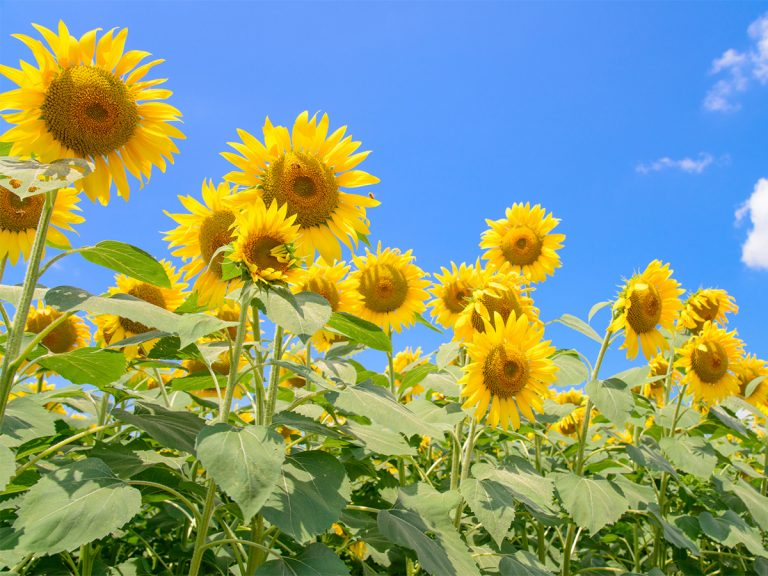

In [10]:
from IPython.display import Image
Image("temp/sunflower.jpg")

In [ ]:
<start> a bunch of colorful flowers in a tree . <end>

## 【問題3】Kerasで動かしたい場合はどうするかを調査

・Ｐｙｔｏｒｃｈで定義されて学習された学習済みモデルを、ＯＮＮＸに変換して記録する。  
・ＯＮＮＸ形式のモデルをKerasのモデルに変換する。  
・Ｐｙｔｏｒｃｈによる学習済みモデルと、Ｋｅｒａｓに変換された学習済みモデルの推論結果を比較して整合性を確認する。  

参考：
https://pytorch.org/docs/stable/onnx.html#example-end-to-end-alexnet-from-pytorch-to-onnx  
https://pypi.org/project/onnx2keras/



##  【問題4】（アドバンス課題）コードリーディングと書き換え   
　モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。  

・model.pyのコードリーディング  
pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial  
（他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。  
これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。） 　 

参考：  
https://tzmi.hatenablog.com/entry/2019/12/31/002627  
https://qiita.com/perrying/items/857df46bb6cdc3047bd8  


https://ja.coder.work/so/python/561870  
resnet.children()について。ResNetモデルの場合、pytorchのResNetモデルはnnモジュールで構成されるため、子属性を使用してレイヤーにアクセスできます。  

In [1]:
## pytorch model.py 原文 ##

import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()     ### nn.moduleを継承定義する際の必須記載。python3系では()内省略可。
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.子属性を使用してresnetの末尾を排除。
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)   # nn.Linearは線形結合を出力（入力サイズ、出力サイズ）。
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():                 ### autogradエンジンを使わずに、勾配計算無しの推論だけ行う。 
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)    # vocab_sizeは、embed_sizeｇは、
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

ModuleNotFoundError: No module named 'torch'

## Kerasへの書き換え　(機械翻訳の、encoder_inputs ～ model.compile)

In [ ]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))  #画像形式の受け入れ
encoder = ResNet152(input_shape, include_top=False)       #Resnet152
encoder_outputs = encoder(encoder_inputs)
encoder_dense = Dense(embeded_size, activation="tanh")#全結合層とBN層の追加。
encoder_outputs = encoder_dense(encoder_outputs)
encoder_bn = BatchNormalization()
encoder_outputs = encoder_bn(encoder_outputs)

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

＜メモ＞  
decoder～compileまでは機械翻訳と同様。
モデルへの入出力データの形式については検討していないが、モデルを定義するだけならば、resnet152への変更、及び、dense層とbn層の追加をすればよいと思えた。

機械翻訳におけるKerasのLSTM出力が3つあるが、マニュアルのどの部分に定義されているのかよくわからなかった→LSTMのreturn_sequenceをTrueにすれば出力が３つ出てくる（outputの他に長期記憶のstate_cと短期記憶のstate_h）。  
参考：https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/  
https://qiita.com/satelli/items/0f4810b698b6cebcbf93
